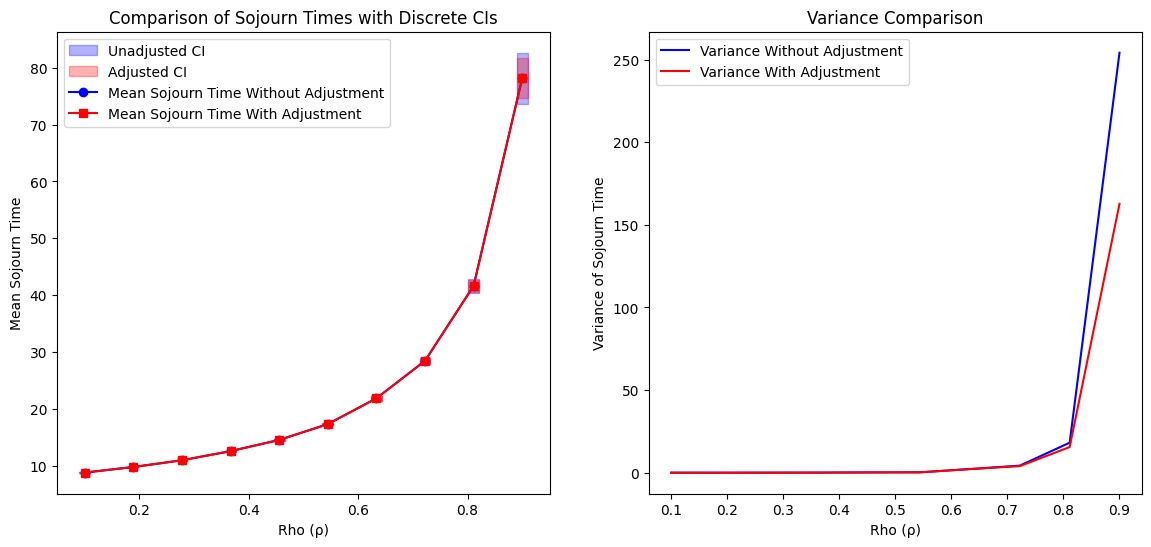

In [6]:
import heapq
import random
from math import log
import numpy as np
import matplotlib.pyplot as plt

class Expon:
    def __init__(self, xmean):
        self.mean = xmean
        self.low = 0.00000001
        self.high = 0.99999999

    def setseed(self, seed):
        random.seed(seed)

    def restore_seed(self):
        random.setstate(self.state)

    def unif(self):
        self.state = random.getstate()
        u = random.uniform(self.low, self.high)
        return u

    def c_unif(self):
        u = self.unif()
        return 1 - u

    def expon(self):
        u = self.unif()
        return -self.mean * log(1 - u)

    def expon2(self):
        u = self.c_unif()
        return -self.mean * log(1 - u)
def run_simulation(N, a_rate, s_rate, arriv, serv, complement=False):
    mean_delays = []
    total_service_times = []
    
    for i in range(50):  # Perform 50 pairs of runs
        clock = 0
        next_arrival = arriv.expon2() if complement else arriv.expon()
        queues = [[] for _ in range(N)]
        customers_in_queues = [0] * N
        total_delay = 0
        total_customers = 0
        total_service_time = 0
        next_departures = [float('inf')] * N
        arrival_times = {}

        while total_customers < 3000:
            next_event_time = min(next_arrival, min(next_departures))
            next_event_queue = 0 if next_event_time == next_arrival else next_departures.index(next_event_time) + 1

            if next_event_queue == 0:
                clock = next_arrival
                total_customers += 1
                customers_in_queues[0] += 1
                heapq.heappush(queues[0], (clock, total_customers))
                arrival_times[total_customers] = clock
                next_arrival += arriv.expon2() if complement else arriv.expon()
                if customers_in_queues[0] == 1:
                    service_time = serv.expon2() if complement else serv.expon()
                    if total_customers > 800:
                        total_service_time += service_time
                    next_departures[0] = queues[0][-1][0] + service_time
            else:
                queue_index = next_event_queue - 1
                clock = next_departures[queue_index]
                _, customer_id = heapq.heappop(queues[queue_index])
                if queue_index == N - 1:
                    if total_customers > 800:
                        total_delay += clock - arrival_times[customer_id]
                customers_in_queues[queue_index] -= 1
                if customers_in_queues[queue_index] == 0:
                    next_departures[queue_index] = float('inf')
                else:
                    service_time = serv.expon2() if complement else serv.expon()
                    if total_customers > 800:
                        total_service_time += service_time
                    next_departures[queue_index] = clock + service_time
                if queue_index < N - 1:
                    customers_in_queues[queue_index + 1] += 1
                    heapq.heappush(queues[queue_index + 1], (clock, customer_id))
                    if customers_in_queues[queue_index + 1] == 1:
                        service_time = serv.expon2() if complement else serv.expon()
                        if total_customers > 800:
                            total_service_time += service_time
                        next_departures[queue_index + 1] = queues[queue_index + 1][-1][0] + service_time

        mean_delay = total_delay / (total_customers - 800)
        mean_delays.append(mean_delay)
        mean_service = total_service_time / (total_customers - 800)
        total_service_times.append(mean_service)
    # print("\nmean_delays:",mean_delays)
    # print("\nmean_service:",total_service_times)
    # print("\ncovariance:",covariance)
    covariance = np.cov(mean_delays, total_service_times)[0][1]
    variance_y = np.var(total_service_times)
    c_opt = -covariance / variance_y
    adjusted_delays = [x + c_opt * (y - np.mean(total_service_times)) for x, y in zip(mean_delays, total_service_times)]

    return mean_delays, adjusted_delays

def calculate_ci(data):
    mean = np.mean(data)
    sem = np.std(data, ddof=1) / np.sqrt(len(data))
    ci_lower = mean - 1.96 * sem
    ci_upper = mean + 1.96 * sem
    return mean, ci_lower, ci_upper

N = 8
s_rate = 1.0
rhos = np.linspace(0.1, 0.9, 10)
all_mean_delays = []
all_adjusted_delays = []
variances_with = []
variances_without = []
results = []

for rho in rhos:
    a_rate = rho * s_rate
    arriv = Expon(1/a_rate)
    serv = Expon(1/s_rate)
    arriv.setseed(1234)
    serv.setseed(56787)
    mean_delays, adjusted_delays = run_simulation(N, a_rate, s_rate, arriv, serv)

    mean, lower, upper = calculate_ci(mean_delays)
    all_mean_delays.append(mean)
    mean_adj, lower_adj, upper_adj = calculate_ci(adjusted_delays)
    all_adjusted_delays.append(mean_adj)
    
    variances_with.append(np.var(adjusted_delays))
    variances_without.append(np.var(mean_delays))

    results.append((rho, mean, lower, upper, mean_adj, lower_adj, upper_adj))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for rho, unadjusted_mean, unadjusted_lower, unadjusted_upper, adjusted_mean, adjusted_lower, adjusted_upper in results:
    plt.fill_between([rho-0.01, rho+0.01], unadjusted_lower, unadjusted_upper, color='blue', alpha=0.3, label='Unadjusted CI' if rho == rhos[0] else "")
    plt.fill_between([rho-0.01, rho+0.01], adjusted_lower, adjusted_upper, color='red', alpha=0.3, label='Adjusted CI' if rho == rhos[0] else "")
plt.plot(rhos, all_mean_delays, '-o', color='blue', label='Mean Sojourn Time Without Adjustment')
plt.plot(rhos, all_adjusted_delays, '-s', color='red', label='Mean Sojourn Time With Adjustment')
plt.xlabel('Rho (ρ)')
plt.ylabel('Mean Sojourn Time')
plt.title('Comparison of Sojourn Times with Discrete CIs')
plt.legend()

# Plotting Variance
plt.subplot(1, 2, 2)
plt.plot(rhos, variances_without, label='Variance Without Adjustment', color='blue')
plt.plot(rhos, variances_with, label='Variance With Adjustment', color='red')
plt.xlabel('Rho (ρ)')
plt.ylabel('Variance of Sojourn Time')
plt.title('Variance Comparison')
plt.legend()
plt.savefig("hw4_q2.pdf")
plt.show()
